# Group 13 - “CA applied to the Stock Market”

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

## Preparations

Create network

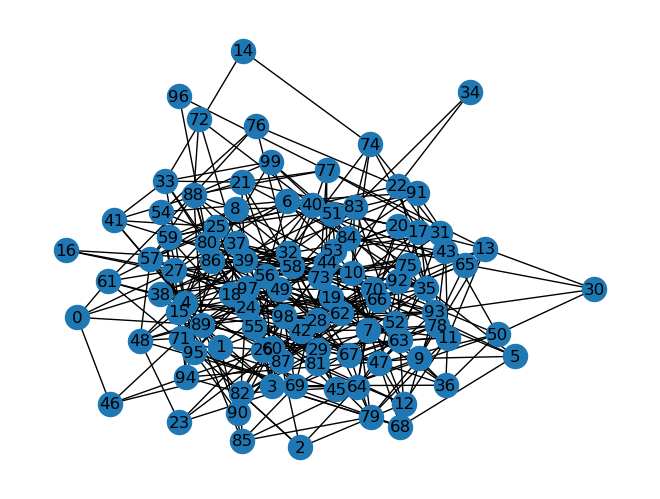

In [3]:
# parameter settings
n = 100  # nodes
p = 8 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)

# Visualizing the network
nx.draw(ER_graph, with_labels=True)
plt.show()

Text(0.5, 1.0, 'Erdős_Rényi Model')

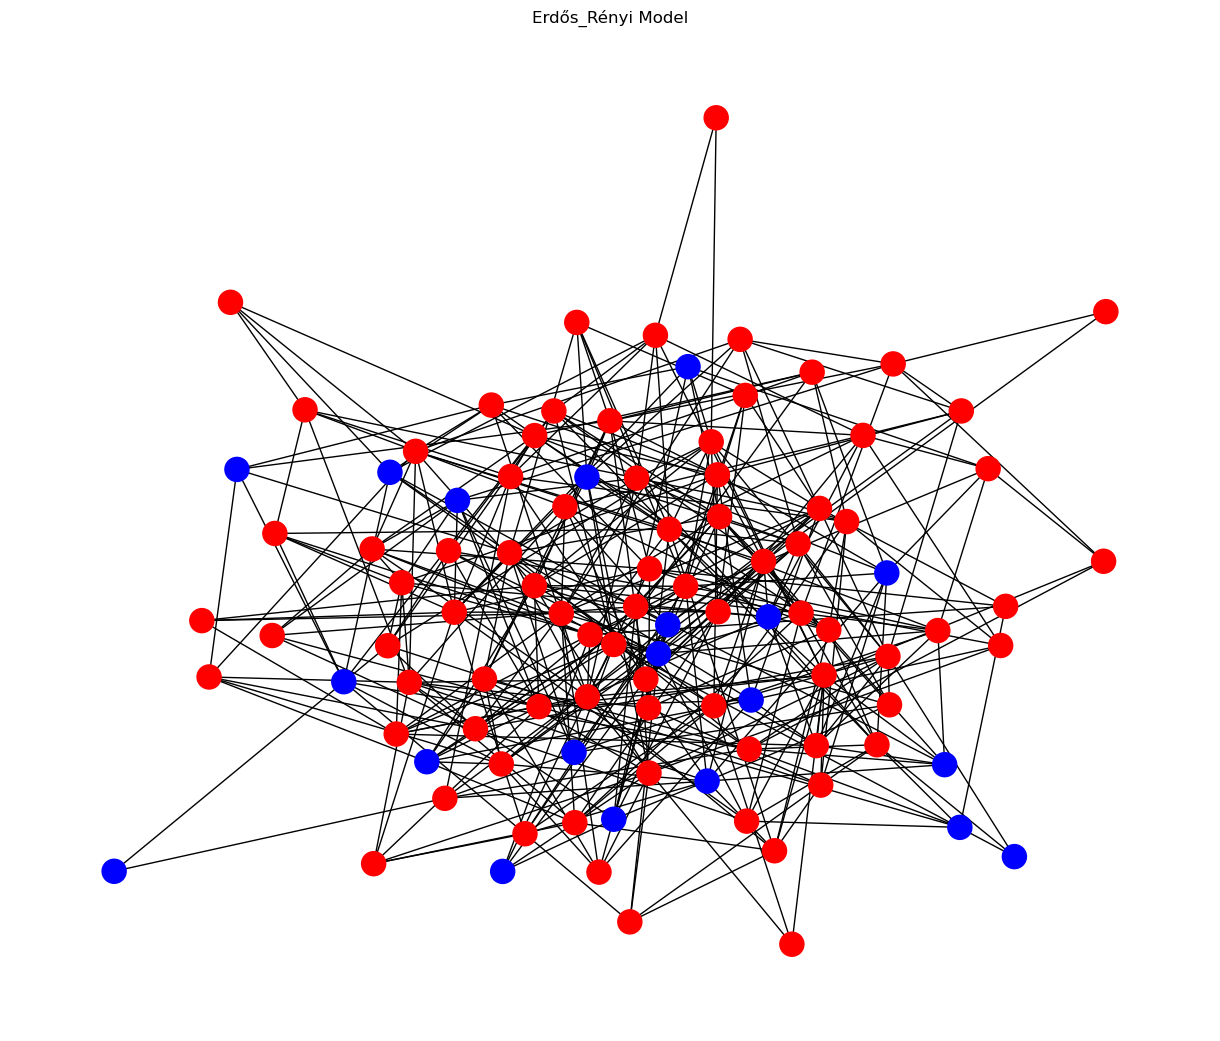

In [4]:
# Assign node type 
alpha_im = 0.2
alpha_fu = 1 - alpha_im
colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes

# 绘制Erdős–Rényi随机图
plt.figure(figsize=(12, 10))
nx.draw(ER_graph, node_color=colors, with_labels=False)
plt.title('Erdős_Rényi Model')

Create a trader class

In [5]:

class Trader:
    def __init__(self, node_id, node_color, graph, parameters):
        """
        Initialize the Trader class.
        :param node_id: Node's ID
        :param node_color: Node's color, representing the Trader's type ('blue' for Imitator, 'red' for Fundamentalist)
        :param graph: The network graph where the node is located.
        """
        self.node_id = node_id
        self.node_color = node_color
        self.type = 'Imitator' if node_color == 'blue' else 'Fundamentalist'
        self.neighbors = list(graph.neighbors(node_id))  # Get the list of neighboring nodes
        self.neighbors_count = len(self.neighbors)  # Number of neighbors
        self.parameters = parameters
        self.trade_level = parameters["trade_level"]
        self.fundamental_value = 100
        # Use normal distribute to create fundamental_values
        #self.fundamental_value = np.random.normal(100, np.sqrt(10))
        self.transaction_quantity = 0  # Initial trading volume is 0
    def fundamentalist_strategy(self, current_price, phi_fu = 1, Mt = 0.05):
        """
        Update the trading quantity for Fundamentalist traders.
        :param current_price: Current price
        :param fundamental_value: Fundamental value
        """
        if self.trade_level == 1:
            self.transaction_quantity = self.fundamental_value - current_price
        elif self.trade_level == 2:
            self.transaction_quantity = self.fundamental_value * (1 + self.parameters["Cfu"] * phi_fu) - current_price
        elif self.trade_level == 3:
            self.transaction_quantity = (self.fundamental_value * (1 + self.parameters["Cfu"] * phi_fu)
            - current_price) * Mt

    def imitator_strategy(self, transaction_quantities, phi_im = 1, Mt = 0.05):
        """
        Update the trading quantity for Imitator traders.
        :param neighbor_transactions: List of neighbor transactions
        """
        neighbor_transactions = []
        for neighbor in self.neighbors:
            neighbor_transactions.append(transaction_quantities[neighbor])
        mean_transaction_quantity = sum(neighbor_transactions) / max(1, len(neighbor_transactions))
        if self.trade_level == 1:
            self.transaction_quantity = mean_transaction_quantity
        elif self.trade_level == 2:
            self.transaction_quantity = mean_transaction_quantity * (1 + self.parameters["Cim"] * phi_im)
        elif self.trade_level == 3:
            self.transaction_quantity = mean_transaction_quantity * (1 + self.parameters["Cim"] * phi_im) * Mt

Class test

In [6]:
# Example: Create a Trader instance
# Assuming we have a pre-created NetworkX graph object and a list of node colors

# Choose a node ID
sample_node_id = 21
# Get the node color
sample_node_color = colors[sample_node_id]
parameters_level1 = {
        "trade_level" : 1
}
# Create a Trader instance
sample_trader = Trader(sample_node_id, sample_node_color, ER_graph, parameters_level1)

# Print information about this instance for verification
print(f"Trader ID: {sample_trader.node_id}")
print(f"Trader Type: {sample_trader.type}")
print(f"Trader Neighbor: {sample_trader.neighbors}")
print(f"Trader Neighbors Count: {sample_trader.neighbors_count}")

Trader ID: 21
Trader Type: Fundamentalist
Trader Neighbor: [33, 39, 41, 49, 58, 77, 83, 84]
Trader Neighbors Count: 8


Impletement

In [7]:
# Construct a Trader object for each node in the random graph
parameters_level1 = {
        "trade_level" : 1
}
traders = [Trader(node_id, color, ER_graph, parameters_level1) for node_id, color in enumerate(colors)]

# Print the type and number of neighbors of the first 5 traders
for trader in traders[20:25]:
    print(f"Trader ID: {trader.node_id}, Type: {trader.type}, Trader Fundamental Value: {trader.fundamental_value}")


Trader ID: 20, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 21, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 22, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 23, Type: Fundamentalist, Trader Fundamental Value: 100
Trader ID: 24, Type: Fundamentalist, Trader Fundamental Value: 100


Update price

In [8]:
def update_price(current_price, transaction_quantities, cp, N):
    """
    Update the price based on the  Level I model.

    :param current_price: The price at the current time point
    :param transaction_quantities: List of transaction quantities for all traders at the current time point
    :param cp: Sensitivity of price to excess demand
    :param N: Number of traders
    :return: Updated price
    """
    Qt = sum(transaction_quantities)  # Calculate the total transaction quantity
    price_change = cp * Qt / N  # Calculate price change based on the rule
    new_price = current_price + price_change  # Update the price
    new_price = max(new_price, 0)  # Ensure the price doesn't go below 0
    return new_price

# Example: Update the price
current_price = 105  # Current price
cp = 0.2  # Sensitivity of price to excess demand
N = len(traders)  # Number of traders
transaction_quantities = [trader.transaction_quantity for trader in traders]  # List of transaction quantities for all traders

# Call the function to update the price
new_price = update_price(current_price, transaction_quantities, cp, N)

# Output the new price
print(f"The new price is: {new_price}")


The new price is: 105.0


## Level I model

In [9]:
#STEP 1: build network
n = 1000  # nodes
p = 8 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)
alpha_ims = [0.2, 0.8]
colorsets = {} # different colorsets means different Proportions of different transaction types
for alpha_im in alpha_ims:
    alpha_fu = 1 - alpha_im
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    colorsets[alpha_im] = colors

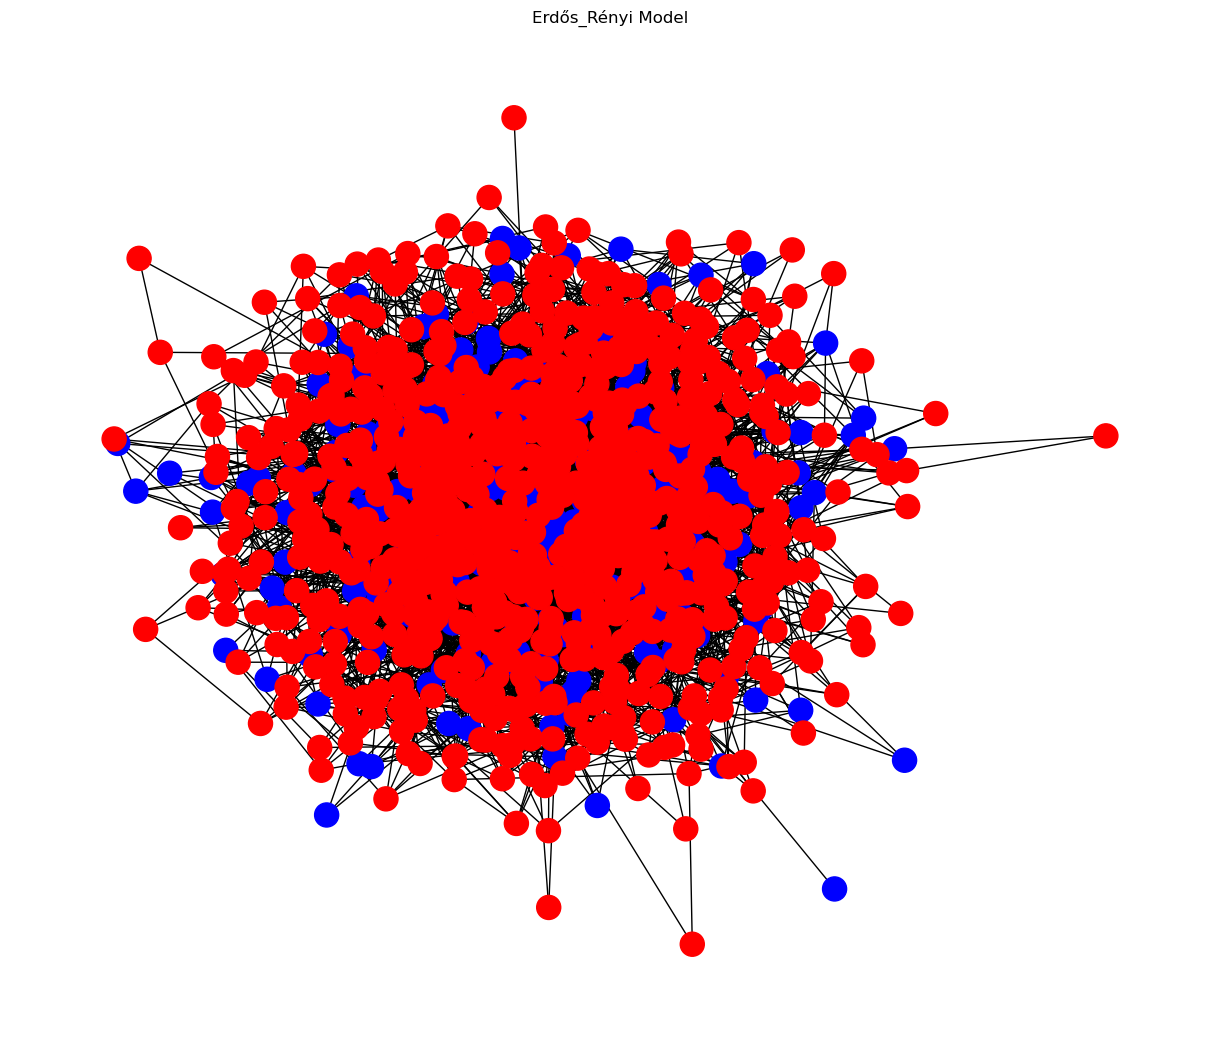

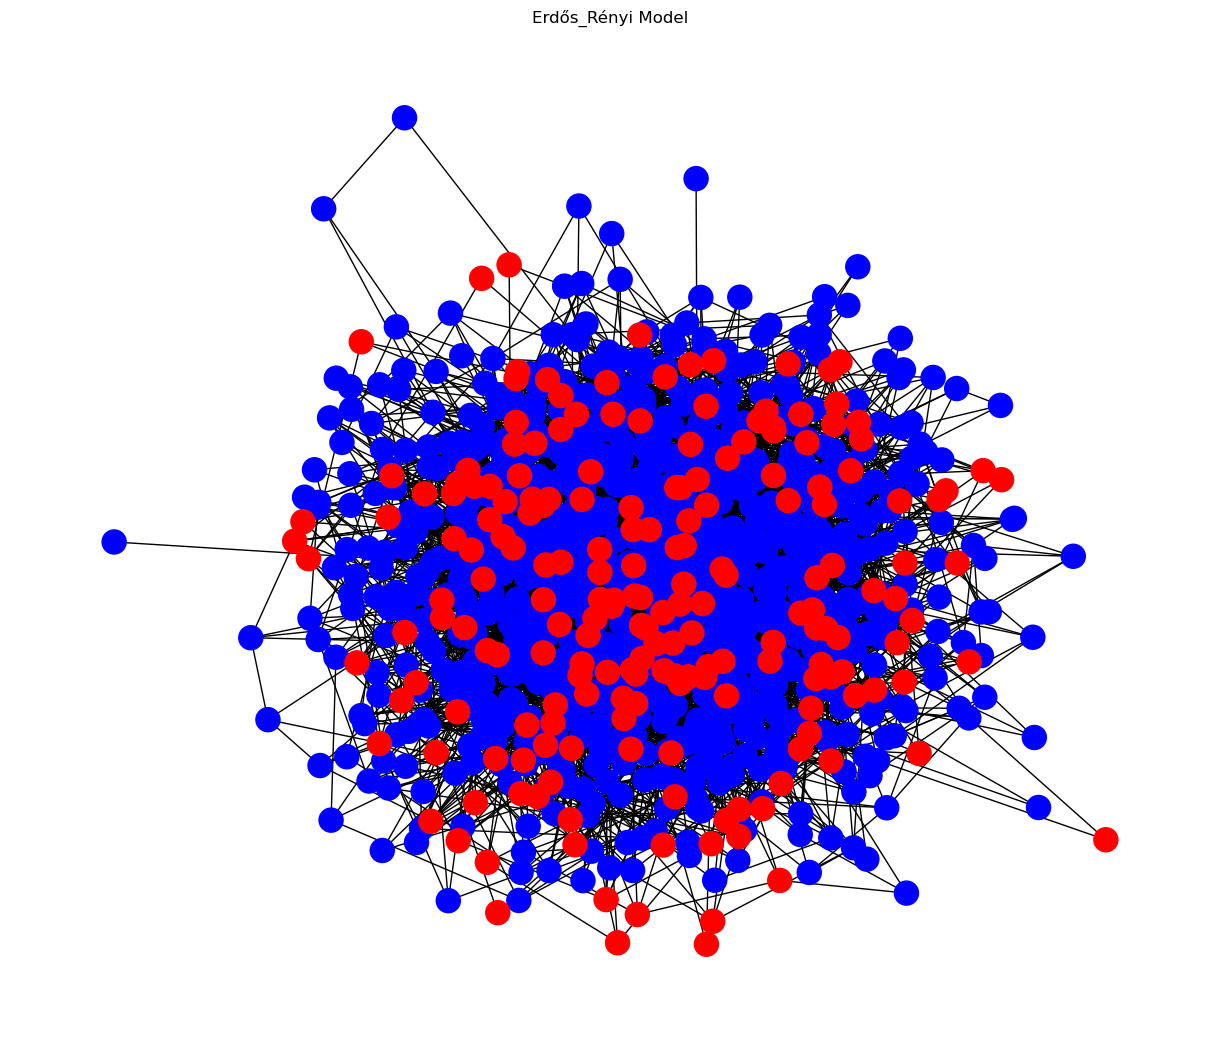

In [10]:
for colors in colorsets.values():
    # Draw Erdős–Rényi random graph
    plt.figure(figsize=(12, 10))
    nx.draw(ER_graph, node_color=colors, with_labels=False)
    plt.title('Erdős_Rényi Model')
    plt.show()

In [11]:
price_historys = {}
for key, colors in colorsets.items():
    parameters_level1 = {
        "trade_level" : 1
    }
    traders = [Trader(node_id, color, ER_graph, parameters_level1) for node_id, color in enumerate(colors)]

    cp = 0.5  # Sensitivity of price to excess demand
    N = len(traders)  # Number of traders

    total_time_steps = 100  # Total time steps
    initial_price = 105  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]

        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                trader.imitator_strategy(transaction_quantities)  # Assuming here that neighbors already contain the corresponding trader objects
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                trader.fundamentalist_strategy(current_price)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)
    price_historys[key] = price_history


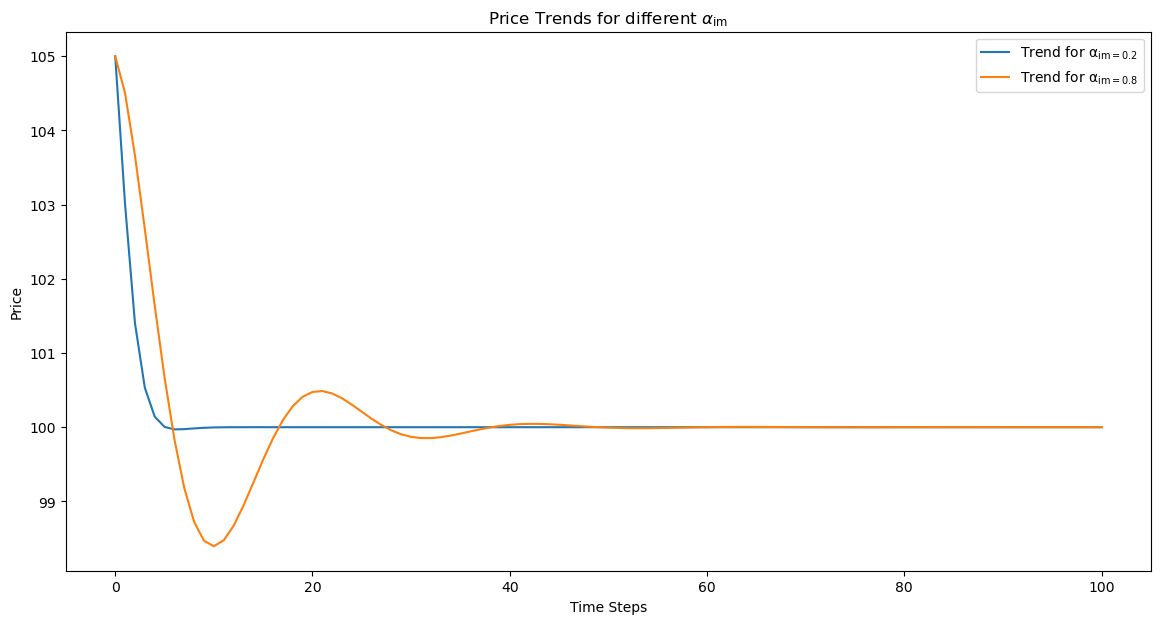

In [12]:
plt.figure(figsize=(14, 7))
for key, values in price_historys.items():
    plt.plot(values, label=r'Trend for $\mathrm{\alpha_{im=' + str(key) + '}}$')
plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Level III model 

Corresponding Formula:  

Price fluctuation level of a stock:

$L^t=\frac{1}{k}\sum_{i=t-k}^{t-1}|P^i-\bar{P}|/\bar{P}$

Current trading activity:  

$M^t(L^t)=\begin{cases}c_lL^t,&L^t\leqslant L_m,\\c_l(-L^t+2L_m)&L^t>L_m,\end{cases}$  

$\eta_{fu}^{t}=1+c_{fu}\phi_{fu}^{t}$  

where $\phi_{fu}^{t}$ is an independent Gaussian random variable with mean 0 and standard
deviation 1 and $c_{fu}$ is a positive parameter indicating the
fundamentalists’ sensitivity to news.
Transaction quantity of fundamentalists:

$\begin{aligned}
q_{i,fu}^{t+1}& =V_{i,fu}^{t+1}M^{t+1}  \\
&=(F\eta_{fu}^{t+1}-P^{t})M^{t+1}
\end{aligned}$

Transaction quantity of imitators:

$\begin{aligned}q_{i,im}^{t+1}&=V_{i,im}^{t+1}M^{t+1}\\&=\langle V_{i,nb}^t\rangle\eta_{im}^{t+1}M^{t+1}\end{aligned}$

Price update rule:

$P^{t+1}=P^t+\frac{c_pQ^t}N$

Create network

In [13]:
#STEP 1: build network
n = 1000  # nodes
p = 8 / n # probability to connect, n * p should be equal to the number 
          # of neighbors in mole field which is 8

# Use NetworkX to create RN network
ER_graph = nx.gnp_random_graph(n, p)
alpha_ims = [0.99,0.98,0.95,0.9,0.85,0.5,0.1]
colorsets = {} # different colorsets means different Proportions of different transaction types
for alpha_im in alpha_ims:
    alpha_fu = 1 - alpha_im
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    colorsets[alpha_im] = colors

In [14]:
a = [103,101,102,101,101,101,101,101,101]
b = len(a)
c = sum(a[-b:]) / b
print(sum(abs(P_i - c) for P_i in a[-b:]) / c / b)

0.00511695906432746


Define trading activity function

In [15]:
def calculate_Lt(prices, k):
    """
    Calculate the stock price volatility level L^t.

    :param prices: Historical price array
    :param k: Number of time steps to consider
    :return: Current price volatility level
    """
    k = min(k, len(prices))
    P_bar = sum(prices[-k:]) / k  # Calculate the average price
    Lt = sum(abs(P_i - P_bar) for P_i in prices[-k:]) / P_bar / k
    return Lt

def calculate_Mt(Lt, Cl, Lm):
    """
    Calculate the current trading activity M^t.

    :param Lt: Current price volatility level
    :param Cl: Parameter
    :param Lm: Threshold
    :return: Current trading activity level
    """
    # The lower bound of Mt is 0.05
    #return np.random.normal(0.5,0.02)
    # return 1
    if Lt <= Lm:
        return max(Cl * Lt, 0.05)
    else:
        return max(Cl * (-Lt + 2 * Lm), 0.05)


Simulate

In [164]:
price_historys = {}
for key, colors in colorsets.items():
    parameters_level3 = {
        "trade_level" : 3,
        "Cl" : 20,
        "Lm" : 0.01,
        "Cfu" : 0.01,
        "Cim" : 0.7,
        "k" : 400
    }
    
    traders = [Trader(node_id, color, ER_graph, parameters_level3) for node_id, color in enumerate(colors)]
    print(0, traders[0].trade_level)

    cp = 0.8  # Sensitivity of price to excess demand
    #Parameter about calculating Mt
    k = 400 
    Cl = 20
    Lm = 0.01
    Mt = 0.05 # Init Mt
    N = len(traders)  # Number of traders

    total_time_steps = 2000  # Total time steps
    initial_price = 100  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]
        phi_fu = np.random.normal(0,1)
        phi_im = np.random.normal(0,1)
        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                trader.imitator_strategy(transaction_quantities, phi_im, Mt)  # Assuming here that neighbors already contain the corresponding trader objects
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                trader.fundamentalist_strategy(current_price, phi_fu, Mt)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)

        # Update Mt
        Lt = calculate_Lt(price_history, k)
        Mt = calculate_Mt(Lt, Cl, Lm)
        
    price_historys[key] = price_history


0 3
0 3
0 3
0 3
0 3
0 3
0 3


Price vs Steps

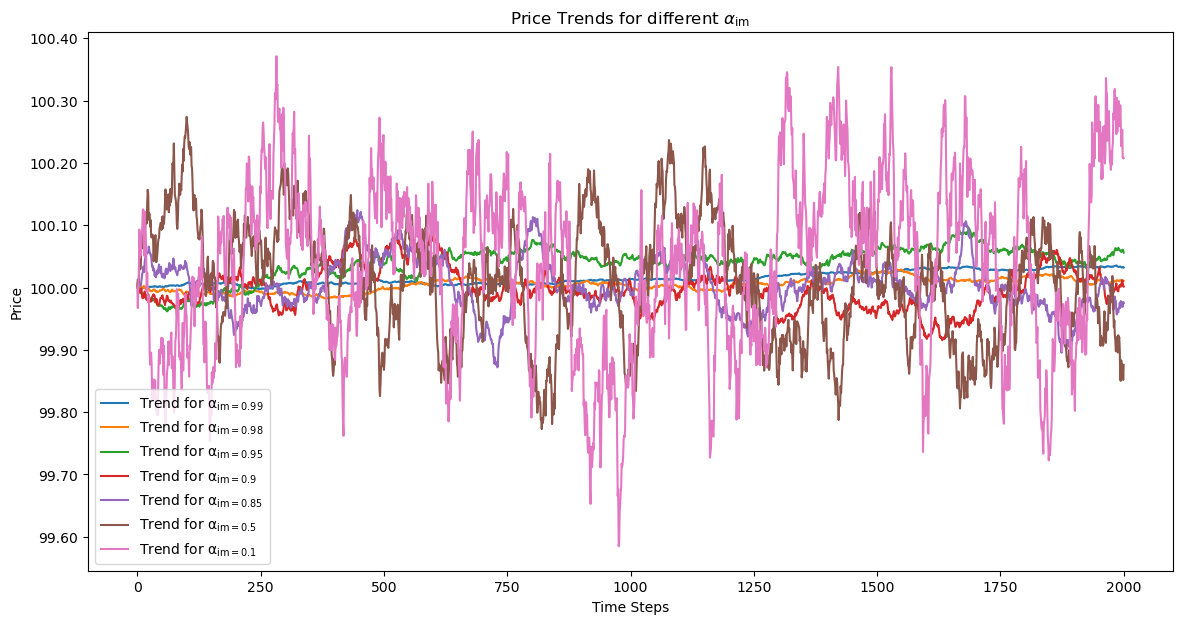

In [165]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(14, 7))
for key, values in price_historys.items():
    plt.plot(values, label=r'Trend for $\mathrm{\alpha_{im=' + str(key) + '}}$')
plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend()
plt.show()

Normalized returns over time

In [19]:
price_history = price_historys
returns = np.diff(price_history)

mean_return = np.mean(returns)
std_return = np.std(returns)
normalized_returns = [(ret - mean_return) / std_return for ret in returns]

# Calculate the distribution of normalized returns
# Use more bins for higher resolution in the histogram
hist, bins = np.histogram(normalized_returns, bins=200, density=True) 
# hist - The number of intervals divided into
# bins - The boarder of the intervals
bin_centers = 0.5 * (bins[1:] + bins[:-1]) 

# Autocorrelation
autocorr_returns = np.correlate(normalized_returns, normalized_returns, mode='full')
autocorr_returns = autocorr_returns[autocorr_returns.size // 2:]
autocorr_returns /= autocorr_returns[0]
# Plot the figures
plt.figure(figsize=(18, 5))

# Plot (a) Time series of normalized returns
plt.subplot(1, 3, 1)
plt.plot(normalized_returns)
plt.xlabel('Time')
plt.ylabel('Normalized Return')
plt.title('Normalized Returns over Time')

# Plot (b) Distribution of normalized returns with only y-axis in log scale
plt.subplot(1, 3, 2)
plt.semilogy(bin_centers, hist, linestyle='None', marker='+')
plt.xlabel('Normalized Return')
plt.ylabel('Probability (log scale)')
plt.title('Probability Distribution of Normalized Returns')

# Plot (c) Autocorrelation function of returns
plt.subplot(1, 3, 3)
plt.plot(autocorr_returns[5:])
plt.xlabel('Time Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Normalized Returns')

plt.tight_layout()
plt.show()

ValueError: diff requires input that is at least one dimensional

In [20]:
from arch import arch_model

# 假设你已经有了收益率数据，存储在变量returns中
# 拟合GARCH(1,1)模型
price_history = price_historys[0.7]
returns = np.diff(price_history)
mean_return = np.mean(returns)
std_return = np.std(returns)
normalized_returns = [(ret - mean_return) / std_return for ret in returns]

garch11 = arch_model(normalized_returns, p=1, q=1, rescale=False)
res = garch11.fit(update_freq=10)

# 输出模型结果
print(res.summary())

# 绘制条件方差，观察波动率聚集
fig = res.plot(annualize='D')


KeyError: 0.7

## Simulate function for all levels!

In [148]:
def simulate(timesteps, n, cp, alpha_im, trade_parameters) -> price_history:    

    p = 8 / n # probability to connect, n * p should be equal to the number 
            # of neighbors in mole field which is 8

    # Use NetworkX to create RN network
    ER_graph = nx.gnp_random_graph(n, p)
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    
    traders = [Trader(node_id, color, ER_graph, trade_parameters) for node_id, color in enumerate(colors)]

    N = len(traders)  # Number of traders
    Mt = 0.05
    
    total_time_steps = timesteps  # Total time steps
    initial_price = 100  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]
        phi_fu = np.random.normal(0,1)
        phi_im = np.random.normal(0,1)
        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                if trade_parameters["trade_level"] == 1:
                    trader.imitator_strategy(transaction_quantities)  # Assuming here that neighbors already contain the corresponding trader objects
                elif trade_parameters["trade_level"] == 2: 
                    trader.imitator_strategy(transaction_quantities,phi_im)
                elif trade_parameters["trade_level"] == 3: 
                    trader.imitator_strategy(transaction_quantities,phi_im,Mt)
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                if trade_parameters["trade_level"] == 1:
                    trader.fundamentalist_strategy(current_price)
                elif trade_parameters["trade_level"] == 2:
                    trader.fundamentalist_strategy(current_price,phi_fu)
                elif trade_parameters["trade_level"] == 3:
                    trader.fundamentalist_strategy(current_price,phi_fu,Mt)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)

        if trade_parameters["trade_level"] == 3:
            # Update Mt
            Lt = calculate_Lt(price_history, trade_parameters["k"])
            Mt = calculate_Mt(Lt, trade_parameters["Cl"], trade_parameters["Lm"])
    
    """
    plt.figure(figsize=(14, 7))
    plt.plot(price_history, label=r'Trend for $\mathrm{\alpha_{im=' + str(alpha_im) + '}}$')
    plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.show()
    """
    return price_history
    

Garch test

In [197]:
# Notes: F and P0 are set to be 100
# for level1, trade_parameters only contain "trade_level"
# level2 : "trade_level" "Cfu" "Cim"
# level3 : "trade_level" "Cfu" "Cim" "k" "Cl" "Lm"
#trade_parameters = {"trade_level" : 2,"Cfu" : 0.2 ,"Cim" : 0.7}
trade_parameters = {"trade_level" : 3,"Cl" : 20,"Lm" : 0.01,"Cfu" : 0.2,"Cim" : 0.2,"k" : 400}
alpha_im = 0.5
cp = 0.7
price_history = simulate(timesteps = 1000, n = 1000, cp = cp, alpha_im = alpha_im, 
                                trade_parameters = trade_parameters)
returns = np.diff(price_history)
mean_return = np.mean(returns)
std_return = np.std(returns)
normalized_returns = [(ret - mean_return) / std_return for ret in returns]

garch11 = arch_model(normalized_returns, p=1, q=1, rescale=False)
res = garch11.fit(update_freq=10, disp='off')

# 提取条件方差
conditional_variance = res.conditional_volatility
"""
# 可视化条件方差来检查波动率聚集
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(conditional_variance)
plt.title('Conditional Variance over Time')
plt.xlabel('Time')
plt.ylabel('Conditional Variance')
plt.show()
"""

# Only the values of alpha and beta need to be displayed along with their significance levels
results = {}
results["cp"] = cp
results["alpha_im"] = alpha_im
results["alpha1_coef"] = res.params['alpha[1]']
results["alpha1_pvalue"]  = res.pvalues['alpha[1]']

results["beta1_coef"] = res.params['beta[1]']
results["beta1_pvalue"] = res.pvalues['beta[1]']
# 输出模型结果
results_rounded = {key: round(value, 3) for key, value in results.items()}

print(res.summary())
#print(results_rounded)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1251.29
Distribution:                  Normal   AIC:                           2510.58
Method:            Maximum Likelihood   BIC:                           2530.21
                                        No. Observations:                 1000
Date:                Thu, Feb 01 2024   Df Residuals:                      999
Time:                        21:26:00   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0150  2.359e-02      0.636      0.525 

Garch function

In [26]:
def garch(cp,alpha_im):
    
    # Notes: F and P0 are set to be 100
    # for level1, trade_parameters only contain "trade_level"
    # level2 : "trade_level" "Cfu" "Cim"
    # level3 : "trade_level" "Cfu" "Cim" "k" "Cl" "Lm"
    #trade_parameters = {"trade_level" : 2,"Cfu" : 0.2 ,"Cim" : 0.7}
    trade_parameters = {"trade_level" : 3,"Cl" : 20,"Lm" : 0.01,"Cfu" : 0.2,"Cim" : 0.2,"k" : 400}

    price_history = simulate(timesteps = 1000, n = 1000, cp = cp, alpha_im = alpha_im, 
                                    trade_parameters = trade_parameters)
    returns = np.diff(price_history)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    normalized_returns = [(ret - mean_return) / std_return for ret in returns]

    garch11 = arch_model(normalized_returns, p=1, q=1, rescale=False)
    res = garch11.fit(update_freq=10, disp='off')

    # 提取条件方差
    conditional_variance = res.conditional_volatility
    
    # 可视化条件方差来检查波动率聚集
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(conditional_variance)
    plt.title('Conditional Variance over Time')
    plt.xlabel('Time')
    plt.ylabel('Conditional Variance')
    plt.show()
    """
    

    # Only the values of alpha and beta need to be displayed along with their significance levels
    results = {}
    results["cp"] = cp
    results["alpha_im"] = alpha_im
    results["alpha1_coef"] = res.params['alpha[1]']
    results["alpha1_pvalue"]  = res.pvalues['alpha[1]']

    results["beta1_coef"] = res.params['beta[1]']
    results["beta1_pvalue"] = res.pvalues['beta[1]']
    # 输出模型结果
    results_rounded = {key: round(value, 3) for key, value in results.items()}

    #print(res.summary())
    
    return results_rounded



Run multiple times

In [27]:
cp = 0.1
alpha_im = 0.1
simulation_time = 20
total_results = {
    "cp" : cp,
    "alpha_im" : alpha_im,
    "alpha1_coef" : [],
    "alpha1_pvalue" : [],
    "beta1_coef" : [],
    "beta1_pvalue": []
}
for _ in range(simulation_time):
    return_value = garch(cp,alpha_im)
    total_results["alpha1_coef"].append(return_value["alpha1_coef"])
    total_results["alpha1_pvalue"].append(return_value["alpha1_pvalue"])
    total_results["beta1_coef"].append(return_value["beta1_coef"])
    total_results["beta1_pvalue"].append(return_value["beta1_pvalue"])
print(total_results)  

{'cp': 0.1, 'alpha_im': 0.1, 'alpha1_coef': [0.051, 0.05, 0.028, 0.032, 0.042, 0.022, 0.024, 0.023, 0.063, 0.067, 0.066, 0.029, 0.07, 0.04, 0.022, 0.036, 0.025, 0.04, 0.043, 0.026], 'alpha1_pvalue': [0.0, 0.0, 0.002, 0.0, 0.0, 0.003, 0.048, 0.042, 0.0, 0.0, 0.0, 0.0, 0.383, 0.006, 0.553, 0.0, 0.002, 0.001, 0.001, 0.003], 'beta1_coef': [0.946, 0.95, 0.97, 0.968, 0.958, 0.978, 0.976, 0.973, 0.937, 0.933, 0.934, 0.971, 0.925, 0.96, 0.978, 0.964, 0.975, 0.96, 0.953, 0.974], 'beta1_pvalue': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


In [28]:
def run_model(cp, alpha_im,simulation_time) -> total_results:
    total_results = {
    "cp" : cp,
    "alpha_im" : alpha_im,
    "alpha1_coef" : [],
    "alpha1_pvalue" : [],
    "beta1_coef" : [],
    "beta1_pvalue": []
    }
    for _ in range(simulation_time):
        return_value = garch(cp,alpha_im)
        total_results["alpha1_coef"].append(return_value["alpha1_coef"])
        total_results["alpha1_pvalue"].append(return_value["alpha1_pvalue"])
        total_results["beta1_coef"].append(return_value["beta1_coef"])
        total_results["beta1_pvalue"].append(return_value["beta1_pvalue"])
    return total_results

Plot function

In [29]:
import pandas as pd
import seaborn as sns
def plot_function(total_results):
        # Calculate proportions of pvalues < 0.05
        alpha_pvalue_less_than_05 = [pval for pval in total_results['alpha1_pvalue'] if pval < 0.05]
        alpha_pvalue_greater_equal_05 = [pval for pval in total_results['alpha1_pvalue'] if pval >= 0.05]
        beta_pvalue_less_than_05 = [pval for pval in total_results['beta1_pvalue'] if pval < 0.05]
        beta_pvalue_greater_equal_05 = [pval for pval in total_results['beta1_pvalue'] if pval >= 0.05]

        # Histogram of proportions
        plt.figure(figsize=(10, 5))
        plt.bar(['Alpha p < 0.05', 'Alpha p >= 0.05', 'Beta p < 0.05', 'Beta p >= 0.05'], 
                [len(alpha_pvalue_less_than_05), len(alpha_pvalue_greater_equal_05), 
                len(beta_pvalue_less_than_05), len(beta_pvalue_greater_equal_05)], 
                color=['blue', 'red', 'green', 'red'])
        plt.title(f'Count of p-values Relative to 0.05 Threshold. (alpha_im = {"{:.2f}".format(total_results["alpha_im"])}, cp = {"{:.2f}".format(total_results["cp"])})')
        plt.ylabel('Count')
        plt.show()

        # Preparing the data for alpha and beta coefficients
        alpha_data = [coef for coef, pval in zip(total_results['alpha1_coef'], total_results['alpha1_pvalue']) if pval < 0.05]
        beta_data = [coef for coef, pval in zip(total_results['beta1_coef'], total_results['beta1_pvalue']) if pval < 0.05]

        # Creating a figure with two subplots having separate y-axes
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plotting the boxplot for alpha coefficients
        sns.boxplot(y=alpha_data, ax=axes[0], color='blue')  # Ensuring data is on the y-axis
        axes[0].set_title('Alpha Coefficients (p < 0.05)', fontsize = 16)
        axes[0].set_ylabel('Coefficient Value', fontsize = 15)
        axes[0].set_xlabel('Alpha', fontsize = 15)

        # Plotting the boxplot for beta coefficients
        sns.boxplot(y=beta_data, ax=axes[1], color='green')  # Ensuring data is on the y-axis
        axes[1].set_title('Beta Coefficients (p < 0.05)', fontsize = 16)
        axes[1].set_ylabel('Coefficient Value', fontsize = 15)
        axes[1].set_xlabel('Beta', fontsize = 15)

        plt.tight_layout()
        plt.show()

In [ ]:
plot_function(total_results)

Generate GARCH model results under various parameter combinations

In [ ]:
cps = np.linspace(0.1,0.9,10)
alpha_ims = np.linspace(0.1,0.9,10)
cps = np.linspace(0.1,0.2,10)
alpha_ims = [0.5]
simulation_time = 5
for cp in cps:
    for alpha_im in alpha_ims:
        total_results = run_model(cp,alpha_im,simulation_time)
        print(total_results)

Make a table function and return the results of cp, alpha_im, and garch models

In [152]:
def processed_garch_result(total_results):
    # Calculate proportions of pvalues < 0.05
    alpha_pvalues = [pval for pval in total_results['alpha1_pvalue']]
    beta_pvalues = [pval for pval in total_results['beta1_pvalue']]

    alpha_pvalue_mean = np.mean(alpha_pvalues)
    beta_pvalue_mean = np.mean(beta_pvalues)

    alpha_data = [coef for coef, pval in zip(total_results['alpha1_coef'], total_results['alpha1_pvalue']) if pval < 0.05]
    beta_data = [coef for coef, pval in zip(total_results['beta1_coef'], total_results['beta1_pvalue']) if pval < 0.05]

    alpha_mean = np.mean(alpha_data)
    beta_mean = np.mean(beta_data)

    table_analyse = {'cp': total_results["cp"], 'alpha_im': total_results["alpha_im"]}
    table_analyse["alpha_pvalue_mean"] = alpha_pvalue_mean
    table_analyse["beta_pvalue_mean"] = beta_pvalue_mean
    table_analyse["alpha_mean"] = alpha_mean
    table_analyse["beta_mean"] = beta_mean

    return table_analyse

In [ ]:
cps = np.linspace(0.1, 0.9, 9)
alpha_ims = np.linspace(0.1, 0.9, 9)
simulation_time = 30
final_results = []
for cp in cps:
    for alpha_im in alpha_ims:
        total_results = run_model(cp,alpha_im,simulation_time)
        final_result = processed_garch_result(total_results)
        final_results.append(final_result)
        print(final_result)
print(final_results)

In [82]:
data_store = final_results
print(data_store)

[{'cp': 0.1, 'alpha_im': 0.1, 'alpha_pvalue_mean': 0.14683333333333332, 'beta_pvalue_mean': 0.009266666666666668, 'alpha_mean': 0.03991304347826087, 'beta_mean': 0.9649310344827586}, {'cp': 0.1, 'alpha_im': 0.2, 'alpha_pvalue_mean': 0.09626666666666667, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.03676, 'beta_mean': 0.9650666666666669}, {'cp': 0.1, 'alpha_im': 0.3, 'alpha_pvalue_mean': 0.14476666666666665, 'beta_pvalue_mean': 0.007766666666666667, 'alpha_mean': 0.030565217391304356, 'beta_mean': 0.9711379310344828}, {'cp': 0.1, 'alpha_im': 0.4, 'alpha_pvalue_mean': 0.1509, 'beta_pvalue_mean': 0.03333333333333333, 'alpha_mean': 0.031809523809523815, 'beta_mean': 0.9697931034482757}, {'cp': 0.1, 'alpha_im': 0.5, 'alpha_pvalue_mean': 0.1371666666666667, 'beta_pvalue_mean': 0.047066666666666666, 'alpha_mean': 0.03204545454545455, 'beta_mean': 0.9663571428571428}, {'cp': 0.1, 'alpha_im': 0.6, 'alpha_pvalue_mean': 0.24409999999999996, 'beta_pvalue_mean': 0.11076666666666667, 'alpha_mean': 0.027

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid for plotting
cps = np.linspace(0.1, 0.9, 9)
alpha_ims = np.linspace(0.1, 0.9, 9)
cps_round = [format(cp,'.3f') for cp in cps] 
alpha_ims_round = [format(alpha_im,'.3f')  for alpha_im in alpha_ims] 
def garch_final_plot(cps,alpha_ims,ffresults):
    cps_round = [format(cp,'.3f') for cp in cps] 
    alpha_ims_round = [format(alpha_im,'.3f')  for alpha_im in alpha_ims] 
    cp_grid, alpha_im_grid = np.meshgrid(cps, alpha_ims)

    # Initialize the plot data
    alpha_values = np.empty(cp_grid.shape, dtype=object)
    beta_values = np.empty(cp_grid.shape, dtype=object)

    # Populate the plot data based on the conditions
    for data in ffresults:
        
        #cp_index = np.where(cps == data['cp'])[0][0]
        #alpha_im_index = np.where(alpha_ims == data['alpha_im'])[0][0]

        cpss = np.array(cps)
        # Find the index of the closest value in b to a
        cp_index = np.abs(cpss - data['cp']).argmin()

        alpha_imss = np.array(alpha_ims)
        # Find the index of the closest value in b to a
        alpha_im_index = np.abs(alpha_imss - data['alpha_im']).argmin()
        
        # For alpha
        if data['alpha_pvalue_mean'] < 0.05:
            alpha_values[alpha_im_index, cp_index] = f"{data['alpha_mean']:.3f}"
        else:
            alpha_values[alpha_im_index, cp_index] = "n.s."  # Not significant

        # For beta
        if data['beta_pvalue_mean'] < 0.05:
            beta_values[alpha_im_index, cp_index] = f"{data['beta_mean']:.3f}"
        else:
            beta_values[alpha_im_index, cp_index] = "n.s."  # Not significant
    

    # Function to plot the grid
    def plot_data_grid(data_grid, title, xlabel, ylabel):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Create a color map that uses green for significant values and red for not significant
        colors = np.where(data_grid == "n.s.", 'red', 'green')
        
        # Plot the data
        table = ax.table(cellText=data_grid, cellColours=colors, loc='center',
                        cellLoc='center', rowLabels=alpha_ims_round, colLabels=cps_round)
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)

        # Hide the axes
        ax.axis('tight')
        ax.axis('off')
        save_path = r'C:\Users\98398\Desktop\P3 results\plots\RN_beta.png'
        plt.savefig(save_path, dpi=500)
        plt.show()

    # Plotting the grid for alpha
    plot_data_grid(alpha_values, 'Alpha Coefficient Significance Grid(RN model)', 'cp', 'alpha_im')

    # Plotting the grid for beta
    plot_data_grid(beta_values, 'Beta Coefficient Significance Grid(RN model)', 'cp', 'alpha_im')


In [ ]:
cps = np.linspace(0.1, 0.9, 9)
alpha_ims = np.linspace(0.01, 0.1, 5)
simulation_time = 30
final_results2 = []
for cp in cps:
    for alpha_im in alpha_ims:
        total_results = run_model(cp,alpha_im,simulation_time)
        final_result = processed_garch_result(total_results)
        final_results.append(final_result)
        print(final_result)
print(final_results2)

In [ ]:
cps = np.linspace(0.1, 0.9, 9)
alpha_ims = np.linspace(0.9, 0.99, 5)
simulation_time = 30
final_results3 = []
for cp in cps:
    for alpha_im in alpha_ims:
        total_results = run_model(cp,alpha_im,simulation_time)
        final_result = processed_garch_result(total_results)
        final_results.append(final_result)
        print(final_result)
print(final_results3)

Prepare for plots

In [ ]:
final_results_cp_alpha_01_10 = []
final_results_alpha_small_01 = []
final_results_alpha_big_09 = []
for final_result in final_results:
    if final_result["cp"] < 1:
        if final_result["alpha_im"] <= 0.1:
            final_results_alpha_small_01.append(final_result)
        elif final_result["alpha_im"] >= 0.9:
            final_results_alpha_big_09.append(final_result)
        if final_result["alpha_im"] >= 0.1 or final_result["alpha_im"] <= 0.9:
            final_results_cp_alpha_01_10.append(final_result)

print(final_results_cp_alpha_01_10)
print("------------------")
print(final_results_alpha_small_01)
print("------------------")
print(final_results_alpha_big_09)
print("------------------")
for _ in final_results_cp_alpha_01_10:
    print(_)
print("------------------")
for _ in final_results_alpha_small_01:
    print(_)
print("------------------")
for _ in final_results_alpha_big_09:
    print(_)

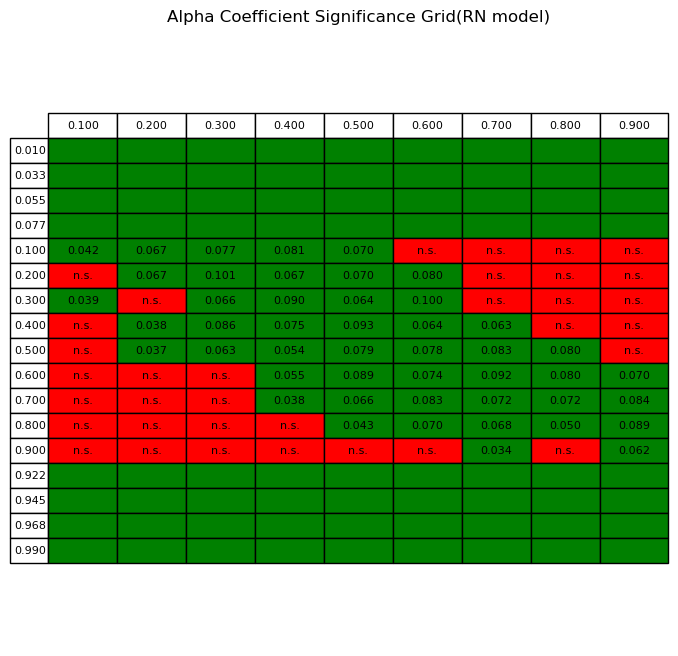

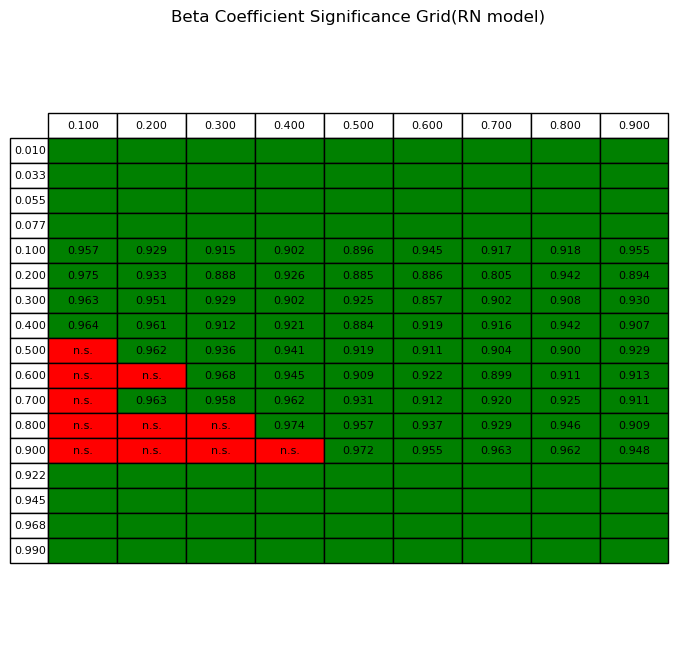

In [159]:
alpha_ims = np.concatenate((np.linspace(0.01, 0.1, 5),np.linspace(0.1, 0.9, 9),np.linspace(0.9, 0.99, 5)))
alpha_ims = [x for i, x in enumerate(alpha_ims) if x not in alpha_ims[:i]]

garch_final_plot(cps,alpha_ims,final_results)

## WS model

In [147]:
def simulate_wsmodel(timesteps, n, cp, alpha_im, trade_parameters) -> price_history:    

    p = 0 # probability to connect, n * p should be equal to the number 
            # of neighbors in mole field which is 8
    k = 4
    # Use NetworkX to create RN network
    
    ws_graph = nx.watts_strogatz_graph(n, k, p)
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    
    traders = [Trader(node_id, color, ws_graph, trade_parameters) for node_id, color in enumerate(colors)]

    N = len(traders)  # Number of traders
    Mt = 0.05
    
    total_time_steps = timesteps  # Total time steps
    initial_price = 100  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]
        phi_fu = np.random.normal(0,1)
        phi_im = np.random.normal(0,1)
        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                if trade_parameters["trade_level"] == 1:
                    trader.imitator_strategy(transaction_quantities)  # Assuming here that neighbors already contain the corresponding trader objects
                elif trade_parameters["trade_level"] == 2: 
                    trader.imitator_strategy(transaction_quantities,phi_im)
                elif trade_parameters["trade_level"] == 3: 
                    trader.imitator_strategy(transaction_quantities,phi_im,Mt)
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                if trade_parameters["trade_level"] == 1:
                    trader.fundamentalist_strategy(current_price)
                elif trade_parameters["trade_level"] == 2:
                    trader.fundamentalist_strategy(current_price,phi_fu)
                elif trade_parameters["trade_level"] == 3:
                    trader.fundamentalist_strategy(current_price,phi_fu,Mt)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)

        if trade_parameters["trade_level"] == 3:
            # Update Mt
            Lt = calculate_Lt(price_history, trade_parameters["k"])
            Mt = calculate_Mt(Lt, trade_parameters["Cl"], trade_parameters["Lm"])
    
    """
    plt.figure(figsize=(14, 7))
    plt.plot(price_history, label=r'Trend for $\mathrm{\alpha_{im=' + str(alpha_im) + '}}$')
    plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.show()
    """
    return price_history
    

In [149]:
def garch_wsmodel(cp,alpha_im):
    
    # Notes: F and P0 are set to be 100
    # for level1, trade_parameters only contain "trade_level"
    # level2 : "trade_level" "Cfu" "Cim"
    # level3 : "trade_level" "Cfu" "Cim" "k" "Cl" "Lm"
    #trade_parameters = {"trade_level" : 2,"Cfu" : 0.2 ,"Cim" : 0.7}
    trade_parameters = {"trade_level" : 3,"Cl" : 20,"Lm" : 0.01,"Cfu" : 0.2,"Cim" : 0.2,"k" : 400}

    price_history = simulate_wsmodel(timesteps = 1000, n = 1000, cp = cp, alpha_im = alpha_im, 
                                    trade_parameters = trade_parameters)
    returns = np.diff(price_history)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    normalized_returns = [(ret - mean_return) / std_return for ret in returns]

    garch11 = arch_model(normalized_returns, p=1, q=1, rescale=False)
    res = garch11.fit(update_freq=10, disp='off')

    # 提取条件方差
    conditional_variance = res.conditional_volatility
    
    # 可视化条件方差来检查波动率聚集
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(conditional_variance)
    plt.title('Conditional Variance over Time')
    plt.xlabel('Time')
    plt.ylabel('Conditional Variance')
    plt.show()
    """
    

    # Only the values of alpha and beta need to be displayed along with their significance levels
    results = {}
    results["cp"] = cp
    results["alpha_im"] = alpha_im
    results["alpha1_coef"] = res.params['alpha[1]']
    results["alpha1_pvalue"]  = res.pvalues['alpha[1]']

    results["beta1_coef"] = res.params['beta[1]']
    results["beta1_pvalue"] = res.pvalues['beta[1]']
    # 输出模型结果
    results_rounded = {key: round(value, 3) for key, value in results.items()}

    #print(res.summary())
    
    return results_rounded



In [150]:
def run_model_wsmodel(cp, alpha_im,simulation_time) -> total_results:
    total_results = {
    "cp" : cp,
    "alpha_im" : alpha_im,
    "alpha1_coef" : [],
    "alpha1_pvalue" : [],
    "beta1_coef" : [],
    "beta1_pvalue": []
    }
    for _ in range(simulation_time):
        return_value = garch_wsmodel(cp,alpha_im)
        total_results["alpha1_coef"].append(return_value["alpha1_coef"])
        total_results["alpha1_pvalue"].append(return_value["alpha1_pvalue"])
        total_results["beta1_coef"].append(return_value["beta1_coef"])
        total_results["beta1_pvalue"].append(return_value["beta1_pvalue"])
    return total_results

In [151]:
def plot_function_wsmodel(total_results):
        # Calculate proportions of pvalues < 0.05
        alpha_pvalue_less_than_05 = [pval for pval in total_results['alpha1_pvalue'] if pval < 0.05]
        alpha_pvalue_greater_equal_05 = [pval for pval in total_results['alpha1_pvalue'] if pval >= 0.05]
        beta_pvalue_less_than_05 = [pval for pval in total_results['beta1_pvalue'] if pval < 0.05]
        beta_pvalue_greater_equal_05 = [pval for pval in total_results['beta1_pvalue'] if pval >= 0.05]

        # Histogram of proportions
        plt.figure(figsize=(10, 5))
        plt.bar(['Alpha p < 0.05', 'Alpha p >= 0.05', 'Beta p < 0.05', 'Beta p >= 0.05'], 
                [len(alpha_pvalue_less_than_05), len(alpha_pvalue_greater_equal_05), 
                len(beta_pvalue_less_than_05), len(beta_pvalue_greater_equal_05)], 
                color=['blue', 'red', 'green', 'red'])
        plt.title(f'Count of p-values Relative to 0.05 Threshold. (alpha_im = {"{:.2f}".format(total_results["alpha_im"])}, cp = {"{:.2f}".format(total_results["cp"])})')
        plt.ylabel('Count')
        plt.show()

        # Preparing the data for alpha and beta coefficients
        alpha_data = [coef for coef, pval in zip(total_results['alpha1_coef'], total_results['alpha1_pvalue']) if pval < 0.05]
        beta_data = [coef for coef, pval in zip(total_results['beta1_coef'], total_results['beta1_pvalue']) if pval < 0.05]

        # Creating a figure with two subplots having separate y-axes
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plotting the boxplot for alpha coefficients
        sns.boxplot(y=alpha_data, ax=axes[0], color='blue')  # Ensuring data is on the y-axis
        axes[0].set_title('Alpha Coefficients (p < 0.05)', fontsize = 16)
        axes[0].set_ylabel('Coefficient Value', fontsize = 15)
        axes[0].set_xlabel('Alpha', fontsize = 15)

        # Plotting the boxplot for beta coefficients
        sns.boxplot(y=beta_data, ax=axes[1], color='green')  # Ensuring data is on the y-axis
        axes[1].set_title('Beta Coefficients (p < 0.05)', fontsize = 16)
        axes[1].set_ylabel('Coefficient Value', fontsize = 15)
        axes[1].set_xlabel('Beta', fontsize = 15)

        plt.tight_layout()
        plt.show()

Final_results

In [161]:
cps = np.linspace(0.1, 0.9, 10)
alpha_ims = np.linspace(0.1, 0.9, 10)
simulation_time = 30
final_results_ws = []
for cp in cps:
    for alpha_im in alpha_ims:
        total_results = run_model_wsmodel(cp,alpha_im,simulation_time)
        final_result = processed_garch_result(total_results)
        final_results_ws.append(final_result)
        print(final_result)


{'cp': 0.1, 'alpha_im': 0.1, 'alpha_pvalue_mean': 0.12986666666666666, 'beta_pvalue_mean': 3.3333333333333335e-05, 'alpha_mean': 0.04775000000000001, 'beta_mean': 0.9606999999999999}
{'cp': 0.1, 'alpha_im': 0.18888888888888888, 'alpha_pvalue_mean': 0.04586666666666666, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.03440909090909092, 'beta_mean': 0.9665}
{'cp': 0.1, 'alpha_im': 0.2777777777777778, 'alpha_pvalue_mean': 0.14036666666666667, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.035777777777777776, 'beta_mean': 0.9691333333333334}
{'cp': 0.1, 'alpha_im': 0.3666666666666667, 'alpha_pvalue_mean': 0.19063333333333332, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.0275625, 'beta_mean': 0.9700333333333335}


d:\Anaconda\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'cp': 0.1, 'alpha_im': 0.4555555555555556, 'alpha_pvalue_mean': 0.13299999999999998, 'beta_pvalue_mean': 0.015533333333333335, 'alpha_mean': 0.029000000000000005, 'beta_mean': 0.9644137931034481}
{'cp': 0.1, 'alpha_im': 0.5444444444444445, 'alpha_pvalue_mean': 0.27203333333333324, 'beta_pvalue_mean': 0.08183333333333334, 'alpha_mean': 0.028000000000000004, 'beta_mean': 0.965925925925926}
{'cp': 0.1, 'alpha_im': 0.6333333333333333, 'alpha_pvalue_mean': 0.3766, 'beta_pvalue_mean': 0.18256666666666668, 'alpha_mean': 0.031700000000000006, 'beta_mean': 0.9625714285714285}
{'cp': 0.1, 'alpha_im': 0.7222222222222222, 'alpha_pvalue_mean': 0.6489333333333333, 'beta_pvalue_mean': 0.23046666666666665, 'alpha_mean': 0.009000000000000001, 'beta_mean': 0.9126000000000001}
{'cp': 0.1, 'alpha_im': 0.8111111111111111, 'alpha_pvalue_mean': 0.6088666666666666, 'beta_pvalue_mean': 0.23156666666666667, 'alpha_mean': 0.031, 'beta_mean': 0.8936999999999999}


d:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'cp': 0.1, 'alpha_im': 0.9, 'alpha_pvalue_mean': 0.6915999999999999, 'beta_pvalue_mean': 0.3438, 'alpha_mean': nan, 'beta_mean': 0.9212}
{'cp': 0.18888888888888888, 'alpha_im': 0.1, 'alpha_pvalue_mean': 0.0, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.0741, 'beta_mean': 0.9232666666666667}
{'cp': 0.18888888888888888, 'alpha_im': 0.18888888888888888, 'alpha_pvalue_mean': 0.0013000000000000002, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.0639, 'beta_mean': 0.9341}
{'cp': 0.18888888888888888, 'alpha_im': 0.2777777777777778, 'alpha_pvalue_mean': 0.0042, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.06424137931034482, 'beta_mean': 0.9364333333333332}


d:\Anaconda\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'cp': 0.18888888888888888, 'alpha_im': 0.3666666666666667, 'alpha_pvalue_mean': 0.019666666666666666, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.05814814814814815, 'beta_mean': 0.9445666666666667}
{'cp': 0.18888888888888888, 'alpha_im': 0.4555555555555556, 'alpha_pvalue_mean': 0.08886666666666666, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.04866666666666667, 'beta_mean': 0.9559333333333332}
{'cp': 0.18888888888888888, 'alpha_im': 0.5444444444444445, 'alpha_pvalue_mean': 0.07976666666666667, 'beta_pvalue_mean': 0.0001, 'alpha_mean': 0.04226923076923077, 'beta_mean': 0.9606333333333335}
{'cp': 0.18888888888888888, 'alpha_im': 0.6333333333333333, 'alpha_pvalue_mean': 0.08719999999999997, 'beta_pvalue_mean': 0.030866666666666667, 'alpha_mean': 0.041100000000000005, 'beta_mean': 0.9657586206896551}
{'cp': 0.18888888888888888, 'alpha_im': 0.7222222222222222, 'alpha_pvalue_mean': 0.15996666666666667, 'beta_pvalue_mean': 0.08263333333333332, 'alpha_mean': 0.02868421052631579, 'beta_mean': 0.96962

d:\Anaconda\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'cp': 0.3666666666666667, 'alpha_im': 0.8111111111111111, 'alpha_pvalue_mean': 0.10386666666666665, 'beta_pvalue_mean': 0.02656666666666667, 'alpha_mean': 0.03661904761904762, 'beta_mean': 0.9677241379310344}
{'cp': 0.3666666666666667, 'alpha_im': 0.9, 'alpha_pvalue_mean': 0.38250000000000006, 'beta_pvalue_mean': 0.13256666666666667, 'alpha_mean': 0.029333333333333336, 'beta_mean': 0.9469166666666666}
{'cp': 0.4555555555555556, 'alpha_im': 0.1, 'alpha_pvalue_mean': 0.0027000000000000006, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.07440000000000001, 'beta_mean': 0.9032333333333334}
{'cp': 0.4555555555555556, 'alpha_im': 0.18888888888888888, 'alpha_pvalue_mean': 0.0004333333333333333, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.07933333333333331, 'beta_mean': 0.9054}
{'cp': 0.4555555555555556, 'alpha_im': 0.2777777777777778, 'alpha_pvalue_mean': 0.0, 'beta_pvalue_mean': 0.0, 'alpha_mean': 0.07976666666666668, 'beta_mean': 0.9063}
{'cp': 0.4555555555555556, 'alpha_im': 0.3666666666666667, 'al

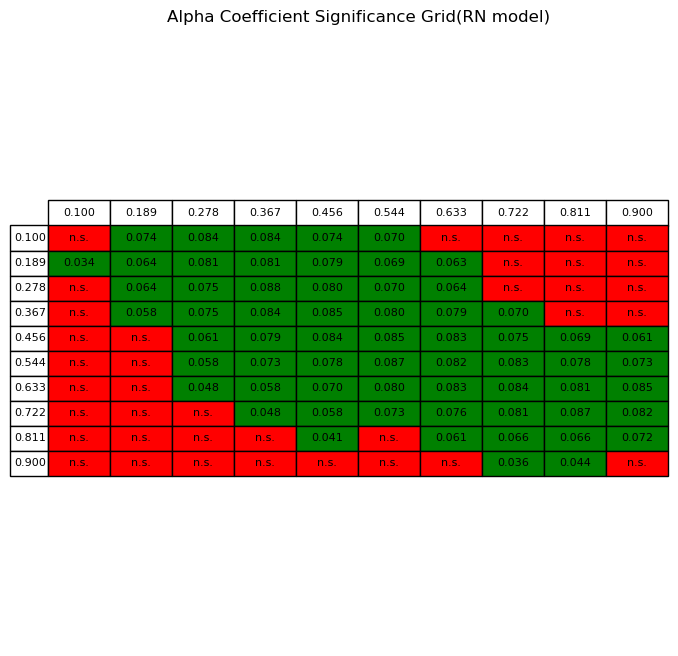

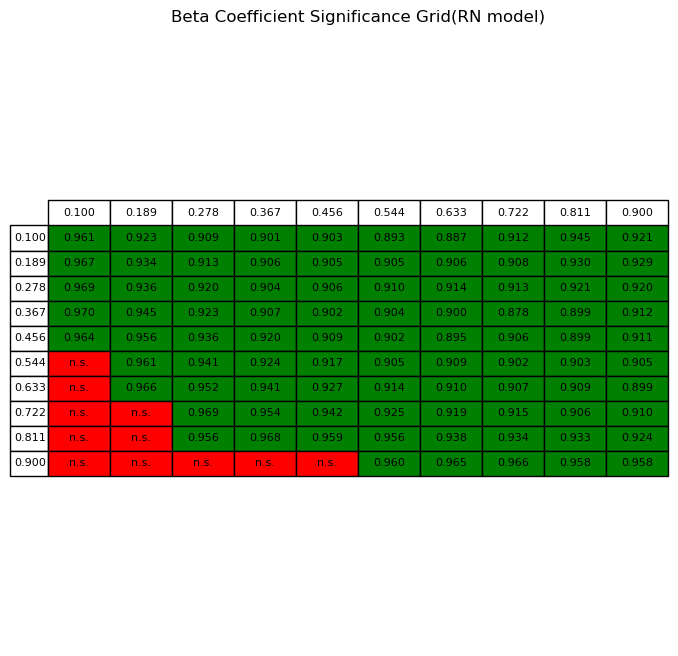

In [162]:
garch_final_plot(cps,alpha_ims,final_results_ws)

## Use different Cfu setting and alpha_fu

In [166]:
def simulate(timesteps, n, cp, alpha_im, trade_parameters) -> price_history:    

    p = 8 / n # probability to connect, n * p should be equal to the number 
            # of neighbors in mole field which is 8

    # Use NetworkX to create RN network
    ER_graph = nx.gnp_random_graph(n, p)
    colors = ["blue" if i < n * alpha_im else "red" for i in range(n)] # n for the number of nodes
    
    traders = [Trader(node_id, color, ER_graph, trade_parameters) for node_id, color in enumerate(colors)]

    N = len(traders)  # Number of traders
    Mt = 0.05
    
    total_time_steps = timesteps  # Total time steps
    initial_price = 100  # Initial price
    price_history = [initial_price]
    transaction_quantities = [trader.transaction_quantity for trader in traders]

    for _ in range(total_time_steps):
        # Get the current price
        current_price = price_history[-1]
        phi_fu = np.random.normal(0,1)
        phi_im = np.random.normal(0,1)
        # Update traders' transaction quantities
        for trader in traders:
            # For Imitators, we update them based on their neighbors' transaction quantities
            if trader.type == 'Imitator':
                if trade_parameters["trade_level"] == 1:
                    trader.imitator_strategy(transaction_quantities)  # Assuming here that neighbors already contain the corresponding trader objects
                elif trade_parameters["trade_level"] == 2: 
                    trader.imitator_strategy(transaction_quantities,phi_im)
                elif trade_parameters["trade_level"] == 3: 
                    trader.imitator_strategy(transaction_quantities,phi_im,Mt)
            # For Fundamentalist traders, we update them based on the current price and fundamental value
            else:
                if trade_parameters["trade_level"] == 1:
                    trader.fundamentalist_strategy(current_price)
                elif trade_parameters["trade_level"] == 2:
                    trader.fundamentalist_strategy(current_price,phi_fu)
                elif trade_parameters["trade_level"] == 3:
                    trader.fundamentalist_strategy(current_price,phi_fu,Mt)

        # Calculate the new price
        transaction_quantities = [trader.transaction_quantity for trader in traders]
        new_price = update_price(current_price, transaction_quantities, cp, len(traders))

        # Update price history
        price_history.append(new_price)

        if trade_parameters["trade_level"] == 3:
            # Update Mt
            Lt = calculate_Lt(price_history, trade_parameters["k"])
            Mt = calculate_Mt(Lt, trade_parameters["Cl"], trade_parameters["Lm"])
    
    """
    plt.figure(figsize=(14, 7))
    plt.plot(price_history, label=r'Trend for $\mathrm{\alpha_{im=' + str(alpha_im) + '}}$')
    plt.title(r'Price Trends for different $\alpha_{\mathrm{im}}$')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.show()
    """
    return price_history
    

In [167]:
def garch_Cfu(Cfu,alpha_im):
    
    # Notes: F and P0 are set to be 100
    # for level1, trade_parameters only contain "trade_level"
    # level2 : "trade_level" "Cfu" "Cim"
    # level3 : "trade_level" "Cfu" "Cim" "k" "Cl" "Lm"
    #trade_parameters = {"trade_level" : 2,"Cfu" : 0.2 ,"Cim" : 0.7}
    trade_parameters = {"trade_level" : 3,"Cl" : 20,"Lm" : 0.01,"Cim" : 0.2,"k" : 400}
    trade_parameters["Cfu"] = Cfu
    cp = 0.5
    price_history = simulate(timesteps = 1000, n = 1000, cp = cp, alpha_im = alpha_im, 
                                    trade_parameters = trade_parameters)
    returns = np.diff(price_history)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    normalized_returns = [(ret - mean_return) / std_return for ret in returns]

    garch11 = arch_model(normalized_returns, p=1, q=1, rescale=False)
    res = garch11.fit(update_freq=10, disp='off')

    # 提取条件方差
    conditional_variance = res.conditional_volatility
    
    # 可视化条件方差来检查波动率聚集
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(conditional_variance)
    plt.title('Conditional Variance over Time')
    plt.xlabel('Time')
    plt.ylabel('Conditional Variance')
    plt.show()
    """
    

    # Only the values of alpha and beta need to be displayed along with their significance levels
    results = {}
    results["cp"] = cp
    results["alpha_im"] = alpha_im
    results["alpha1_coef"] = res.params['alpha[1]']
    results["alpha1_pvalue"]  = res.pvalues['alpha[1]']

    results["beta1_coef"] = res.params['beta[1]']
    results["beta1_pvalue"] = res.pvalues['beta[1]']
    # 输出模型结果
    results_rounded = {key: round(value, 3) for key, value in results.items()}

    #print(res.summary())
    
    return results_rounded



In [178]:
def run_model_Cfu(Cfu, alpha_im,simulation_time) -> total_results:
    total_results = {
    "Cfu" : Cfu,
    "alpha_im" : alpha_im,
    "alpha1_coef" : [],
    "alpha1_pvalue" : [],
    "beta1_coef" : [],
    "beta1_pvalue": []
    }
    for _ in range(simulation_time):
        return_value = garch_Cfu(Cfu,alpha_im)
        total_results["alpha1_coef"].append(return_value["alpha1_coef"])
        total_results["alpha1_pvalue"].append(return_value["alpha1_pvalue"])
        total_results["beta1_coef"].append(return_value["beta1_coef"])
        total_results["beta1_pvalue"].append(return_value["beta1_pvalue"])
    return total_results

In [180]:
def processed_garch_result_Cfu(total_results):
    # Calculate proportions of pvalues < 0.05
    alpha_pvalues = [pval for pval in total_results['alpha1_pvalue']]
    beta_pvalues = [pval for pval in total_results['beta1_pvalue']]

    alpha_pvalue_mean = np.mean(alpha_pvalues)
    beta_pvalue_mean = np.mean(beta_pvalues)

    alpha_data = [coef for coef, pval in zip(total_results['alpha1_coef'], total_results['alpha1_pvalue']) if pval < 0.05]
    beta_data = [coef for coef, pval in zip(total_results['beta1_coef'], total_results['beta1_pvalue']) if pval < 0.05]

    alpha_mean = np.mean(alpha_data)
    beta_mean = np.mean(beta_data)

    table_analyse = {'Cfu': total_results["Cfu"], 'alpha_im': total_results["alpha_im"]}
    table_analyse["alpha_pvalue_mean"] = alpha_pvalue_mean
    table_analyse["beta_pvalue_mean"] = beta_pvalue_mean
    table_analyse["alpha_mean"] = alpha_mean
    table_analyse["beta_mean"] = beta_mean

    return table_analyse

In [192]:
def garch_final_plot_Cfu(cps,alpha_ims,ffresults):
    cps_round = [format(cp,'.3f') for cp in cps] 
    alpha_ims_round = [format(alpha_im,'.3f')  for alpha_im in alpha_ims] 
    cp_grid, alpha_im_grid = np.meshgrid(cps, alpha_ims)

    # Initialize the plot data
    alpha_values = np.empty(cp_grid.shape, dtype=object)
    beta_values = np.empty(cp_grid.shape, dtype=object)

    # Populate the plot data based on the conditions
    for data in ffresults:
        
        #cp_index = np.where(cps == data['cp'])[0][0]
        #alpha_im_index = np.where(alpha_ims == data['alpha_im'])[0][0]

        cpss = np.array(cps)
        # Find the index of the closest value in b to a
        cp_index = np.abs(cpss - data['Cfu']).argmin()

        alpha_imss = np.array(alpha_ims)
        # Find the index of the closest value in b to a
        alpha_im_index = np.abs(alpha_imss - data['alpha_im']).argmin()
        
        # For alpha
        if data['alpha_pvalue_mean'] < 0.05:
            alpha_values[alpha_im_index, cp_index] = f"{data['alpha_mean']:.3f}"
        else:
            alpha_values[alpha_im_index, cp_index] = "n.s."  # Not significant

        # For beta
        if data['beta_pvalue_mean'] < 0.05:
            beta_values[alpha_im_index, cp_index] = f"{data['beta_mean']:.3f}"
        else:
            beta_values[alpha_im_index, cp_index] = "n.s."  # Not significant
    

    # Function to plot the grid
    def plot_data_grid(data_grid, title, xlabel, ylabel):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Create a color map that uses green for significant values and red for not significant
        colors = np.where(data_grid == "n.s.", 'red', 'green')
        
        # Plot the data
        table = ax.table(cellText=data_grid, cellColours=colors, loc='center',
                        cellLoc='center', rowLabels=alpha_ims_round, colLabels=cps_round)
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)

        # Hide the axes
        ax.axis('tight')
        ax.axis('off')
        save_path = r'C:\Users\98398\Desktop\P3 results\plots\RN_Cfu_alpha.png'
        plt.savefig(save_path, dpi=500)
        plt.show()

    # Plotting the grid for alpha
    plot_data_grid(alpha_values, 'Alpha Coefficient Significance Grid(RN model)', 'Cfu', 'alpha_im')

    # Plotting the grid for beta
    plot_data_grid(beta_values, 'Beta Coefficient Significance Grid(RN model)', 'Cfu', 'alpha_im')

Results

In [194]:
Cfus = np.linspace(0.1, 0.9, 10)
alpha_ims = np.linspace(0.1, 0.9, 10)
simulation_time = 30
final_results_Cfu = []
for Cfu in Cfus:
    for alpha_im in alpha_ims:
        total_results = run_model_Cfu(Cfu,alpha_im,simulation_time)
        final_result = processed_garch_result_Cfu(total_results)
        final_results_Cfu.append(final_result)


d:\Anaconda\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\

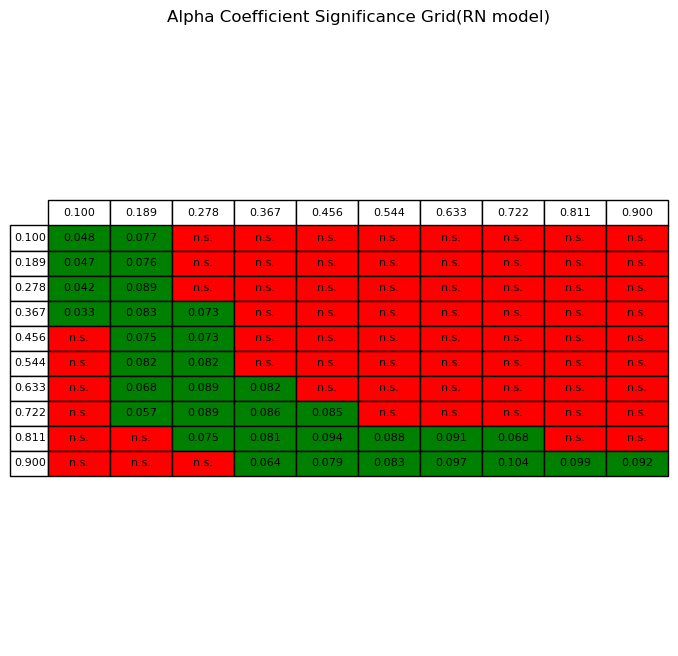

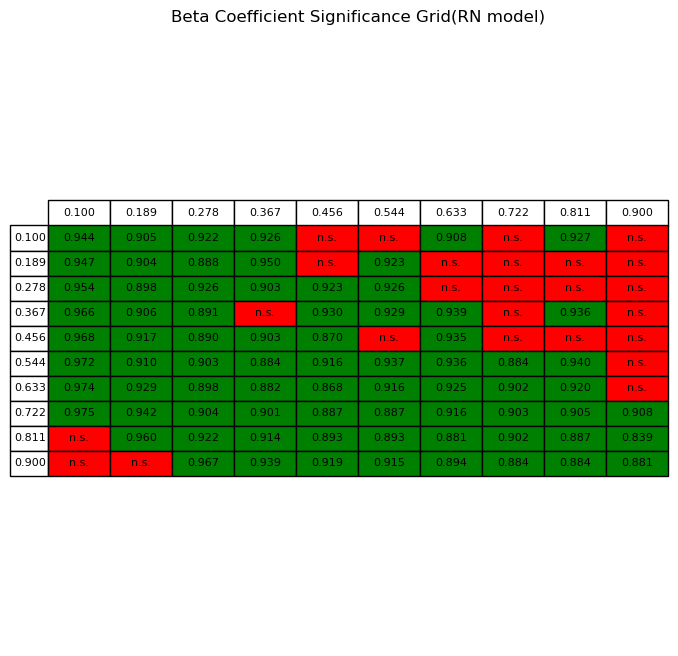

In [195]:
garch_final_plot_Cfu(Cfus,alpha_ims,final_results_Cfu)